In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.time import parse_time
from astropy.io import fits
from astropy.time import Time
import matplotlib.patches as pac
import math
import matplotlib.image as mpimg
from PIL import Image
import os
import math
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import cv2
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from utils import *

In [135]:
pd.options.display.max_columns = None

In [136]:
AIA_DATA_DIR = '../../MVTS_data_preparation/data'
EVENTS_BY_DATE_DIR = './events_by_date/'

In [137]:
CDELT = 0.599733;
HPCCENTER = 4096.0 / 2.0;
rsun_meters = 696000;
dsun_meters = 149600000;
DEFAULT_WIDTH, DEFAULT_HEIGHT = 64, 64
IMAGE_WIDTH, IMAGE_HEIGHT = 512, 512
NMS_KERNEL_SIZE = 4

In [138]:
def GetKMeansData(image, original_shape, k=5):
    image = image.flatten()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    retval, labels, centers = cv2.kmeans(image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]

    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape(original_shape)
    
    return segmented_image

In [139]:
def GetClosestDataFileByDate(dt, rounding, wave='AIA'):
    data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    tmp_dt = dt
    minute = 0
    
    ending = '0094'
    cadence = 6
    if wave == 'HMI':
        ending = 'bz'
        cadence = 12
        
    if(rounding == "down"):
        minute = GetClosestMultipleDown(dt.minute, cadence)
    elif(rounding == "up"):
        minute = GetClosestMultipleUp(dt.minute, cadence)
    
    if(minute == 60):
        tmp_dt = tmp_dt + datetime.timedelta(hours=1)
        minute = 0
    
    
        
    data_time = f'{dt.hour:02d}{minute:02d}'
    data_filename = f'{wave}{data_date}_{data_time}_{ending}.npz'
    
    return data_filename

In [140]:
def GetEventStartFrameData(year, month, event_id, wave='AIA'):
    year_flares_df = pd.read_csv(f'{EVENTS_BY_DATE_DIR}/{year}/{month}.csv')
    data = year_flares_df.loc[year_flares_df.iloc[:, 0] == event_id]
    details, start_datetime, end_datetime = data['fl_goescls'], parse_time(data['event_peaktime']).datetime[0], parse_time(data['event_endtime']).datetime[0]
    data_dir = AIA_DATA_DIR
    if wave == 'HMI':
        data_dir = HMI_DATA_DIR
    
    # find the folders holding the data points
    start_datetime_data_dir = os.path.join(data_dir, f'{start_datetime.year}/{start_datetime.month:02d}/{start_datetime.day:02d}')
    
    # get the data filename closest to the starting and ending dates
    closest_starting_data_file = GetClosestDataFileByDate(start_datetime, "up", wave)
    file_path = os.path.join(start_datetime_data_dir, closest_starting_data_file)
    
    if not os.path.exists(file_path):
        print(f"This frame doesn't exist \n path: {file_path}")
        return
    
    frame_array = np.load(file_path)['x']

    # get the coordinate of the event
    hpc_x, hpc_y = data['hpc_x'], data['hpc_y']
    coord = ConvertHPCToPixXY((hpc_x, hpc_y))
    coord = (coord[0] // 8, IMAGE_HEIGHT-coord[1] // 8)
    coord = (int(coord[0].values[0]), int(coord[1].values[0]))
    print(f'event coordinates: {coord}')
    
    return frame_array, coord

In [141]:
def DemoTwoWaves(year, month, event_id):
    # AIA_path = f'data/{dt.year}/{dt.month:02}/{dt.day:02}/AIA{dt.year}{dt.month:02}{dt.day:02}_{dt.hour:02}{dt.minute:02}_0094.npz'
    # HMI_path = f'data/HMI_Bz/{dt.year}/{dt.month:02}/{dt.day:02}/HMI{dt.year}{dt.month:02}{dt.day:02}_{dt.hour:02}{dt.minute:02}_bz.npz'
    
    AIA, true_coord = GetEventStartFrameData(year, month, event_id, 'AIA')
    HMI, unused = GetEventStartFrameData(year, month, event_id, 'HMI')
    
    fig, axs = plt.subplots(1, 2, figsize=(18,18))
    normalizer=Normalize(0,1)
    im=cm.ScalarMappable(norm=normalizer)
    
    # AIA = LoadNormalizedData(AIA_path)
    # HMI = LoadNormalizedData(HMI_path)
    
    # AIA, HMI = NormalizeData(HMI), NormalizeData(HMI)
    
    AIA_kmeans = GetKMeansData(AIA*255, AIA.shape, 4)
    HMI_kmeans = GetKMeansData(HMI*255, HMI.shape, 4)
    
    plots = [[AIA, HMI],[AIA_kmeans, HMI_kmeans]]
    
    print(f'true coordinate: {true_coord}')
    maxindex = np.unravel_index(AIA.argmax(), AIA.shape)
    axs[0].imshow(AIA)
    # axs[0].scatter(maxindex[1], maxindex[0], color='cyan')
    axs[0].scatter(true_coord[0], true_coord[1], color='r')
    
    maxindex = np.unravel_index(HMI.argmax(), HMI.shape)
    axs[1].imshow(HMI)
    axs[1].scatter(maxindex[1], maxindex[0], color='cyan')
    axs[1].scatter(true_coord[0], true_coord[1], color='r')
        
    fig.colorbar(im, ax=axs.ravel().tolist())
    plt.show()
    
    fig, axs1 = plt.subplots(1, 2, figsize=(18,18))
    # tmp = GetHighestRegion(AIA)
    tmp = NMSImage(AIA)
    print(tmp.shape)
    # tmp = np.reshape(tmp, (-1, int(np.sqrt(tmp.shape))))
    # tmp = np.reshape(tmp, (-1, IMAGE_HEIGHT))
    coords = np.unravel_index(tmp.argmax(), tmp.shape)
    upsampled_coords = (int(coords[0]*5), int(coords[1]*5))
    
    # tmp1 = GetHighestRegion(HMI)
    tmp1 = NMSImage(HMI)
    # tmp1 = np.reshape(tmp1, (-1, int(np.sqrt(tmp1.shape))))
    # tmp1 = np.reshape(tmp1, (-1, IMAGE_HEIGHT))
    coords1 = np.unravel_index(tmp1.argmax(), tmp1.shape)
    
    axs1[0].imshow(AIA)
    axs1[0].scatter(upsampled_coords[1], upsampled_coords[0], color='r')
    
    axs1[1].imshow(tmp1)
    axs1[1].scatter(coords1[1], coords1[0], color='r')
    plt.show()

In [142]:
def GetTopNDistancedPoints(im, n=3, distance_threshold=15):
    im_dict = Image2DToDict(im)
    distanced_points = set()
    im_dict = {k: v for k, v in sorted(im_dict.items(), key=lambda item: item[1], reverse=True)}
    counter = 0
    
    for k, v in im_dict.items():
        if counter >= n:
            break
        if not distanced_points:
            distanced_points.add(k)
            counter += 1
            continue
        above_threshold = True
        for p in distanced_points:
            dist = PixelDistance(k, p)
            if dist < distance_threshold:
                above_threshold = False
                break
        if above_threshold:
            distanced_points.add(k)
            counter += 1
    
    return distanced_points

In [143]:
def GetNMSHighestPoint(im, k=NMS_KERNEL_SIZE):
    nms_im = NMSImage(im, k)
    coords = np.unravel_index(nms_im.argmax(), nms_im.shape)
    upsampled_coords = (math.floor(coords[1]*(k//2)), math.floor(coords[0]*(k//2)))
    
    return upsampled_coords

In [144]:
def GetFrameIncrementing(start_datetime, cadence=6):
    start_datetime_data_dir = os.path.join(AIA_DATA_DIR, f'{start_datetime.year}/{start_datetime.month:02d}/{start_datetime.day:02d}')
    closest_starting_data_file = GetClosestDataFileByDate(start_datetime, "up")
    file_path = os.path.join(start_datetime_data_dir, closest_starting_data_file)
    if not os.path.exists(file_path):
        new_time = start_datetime + datetime.timedelta(minutes=cadence)
        print(f"file doesn't exist - time: {start_datetime} trying: {new_time}")
        return GetFrameIncrementing(new_time)
    
    return np.load(file_path)['x']

In [145]:
def GetFrameDataFromHEKDataRow(data):
    details, start_datetime, end_datetime = data['fl_goescls'], parse_time(data['event_starttime']).datetime, parse_time(data['event_endtime']).datetime
    
    # find the folders holding the data points
    start_datetime_data_dir = os.path.join(AIA_DATA_DIR, f'{start_datetime.year}/{start_datetime.month:02d}/{start_datetime.day:02d}')
    
    closest_starting_data_file = GetClosestDataFileByDate(start_datetime, "up")
    file_path = os.path.join(start_datetime_data_dir, closest_starting_data_file)
    
    # im = GetFrameIncrementing(start_datetime)
    start_datetime_data_dir = os.path.join(AIA_DATA_DIR, f'{start_datetime.year}/{start_datetime.month:02d}/{start_datetime.day:02d}')
    closest_starting_data_file = GetClosestDataFileByDate(start_datetime, "up")
    file_path = os.path.join(start_datetime_data_dir, closest_starting_data_file)
    if not os.path.exists(file_path):
        return None, None
    
    im = np.load(file_path)['x']
    # if not os.path.exists(file_path):
    #     print("path to file doesn't exist")
    #     return
    
    # get the coordinate of the event
    hpc_x, hpc_y = data['hpc_x'], data['hpc_y']
    coord = ConvertHPCToPixXY((hpc_x, hpc_y))
    coord = (coord[0] // 8, IMAGE_HEIGHT-coord[1] // 8)
    coord = (int(coord[0]), int(coord[1]))
    
    return im, coord

In [146]:
def GetPredictedTrueCoords(year, month_range):
    upsample_factor = NMS_KERNEL_SIZE
    total_true_values = []
    total_predicted_values = []
    
    for month in month_range:
        print('----------------------------------------')
        print(f'processing month {month}')
        print('----------------------------------------')
        event_csv = os.path.join(EVENTS_BY_DATE_DIR, f'{year}/{month}.csv')
        if not os.path.exists(event_csv):
            continue
        event_df = pd.read_csv(event_csv, header=0)
        true_values = []
        predicted_values = []
        
        for index, row in event_df.iterrows():
            # if index%10 == 0:
            #     print(f'processing row {index}/{len(event_df)}')
            im, true_coord = GetFrameDataFromHEKDataRow(row)
            if im is None or true_coord is None:
                print('no data exists for this record, skipping')
                continue
            predicted_coord = GetNMSHighestPoint(im)
            # im = NormalizeData(im)
            im = PadMatrixWithValue(im)
            nms_im = NMSImage(im)

            top_n_points = GetTopNDistancedPoints(nms_im)
            true_values.append(true_coord)
            predicted_values.append(list(top_n_points))

        true_values = [[x[0], x[1]] for x in true_values]
        predicted_values = [[[x[1]*upsample_factor, x[0]*upsample_factor] for x in i] for i in predicted_values]
        total_true_values += true_values
        total_predicted_values += predicted_values
        
    print(f'total number of predicted coordinates: {len(total_predicted_values)}')
    
    return total_true_values, total_predicted_values

In [216]:
def GetImageTopNRegionsCutouts(im, N=3):
    upsample_factor = NMS_KERNEL_SIZE
    im = PadMatrixWithValue(im)
    nms_im = NMSImage(im)
    top_n_points = list(GetTopNDistancedPoints(nms_im, N))
    top_n_points = [[x[0]*upsample_factor, x[1]*upsample_factor] for x in top_n_points]
    return GetCoordCutouts(im, top_n_points)

In [217]:
# returns an NxN cutout of an AIA image array centered around the given coordinate

def GetCutout(im, coord, N=DEFAULT_WIDTH):
    x_start = int(coord[0]-N//2)
    x_end = int(coord[0]+N//2)
    y_start = int(coord[1]-N//2)
    y_end = int(coord[1]+N//2)
    cutout_array = im[x_start:x_end, y_start:y_end]
    
    return cutout_array

In [218]:
def GetCoordCutouts(im, coords):
    cutouts = []
    for coord in coords:
        cutouts.append(GetCutout(im, coord))

    return cutouts

In [221]:
t = np.load('../../MVTS_data_preparation/data/2016/01/01/AIA20160101_1830_0094.npz')['x']
t.shape

(512, 512)

[[192, 440], [228, 52], [272, 440]]


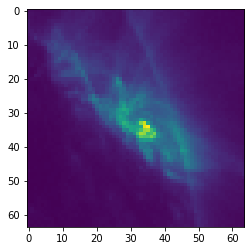

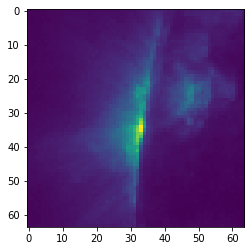

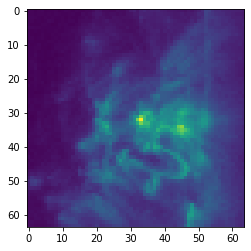

In [222]:
c = GetImageTopNRegionsCutouts(t)
for i in c:
    plt.imshow(i)
    plt.show()

In [178]:
def MultiPointRMSE(true_coords, predicted_coords):
    closest_predicted_coords = []
    for idx, coords in enumerate(predicted_coords):
        min_distance = 9999999
        min_distance_coord = coords[0]
        for coord in coords:
            dist = PixelDistance(coord, true_coords[idx])
            if dist < min_distance:
                min_distance = dist
                min_distance_coord = coord
        closest_predicted_coords.append(min_distance_coord)
    
    rmse =  math.sqrt(mean_squared_error(true_coords, closest_predicted_coords))
    print(f'RMSE: {rmse}')
    
    return rmse

In [151]:
def CalculateKernelSum(im, coord, k=NMS_KERNEL_SIZE):
    k_sum = 0
    x, y = coord[0], coord[1]
    
    for i in range(-k, k):
        for j in range(-k, k):
            try:
                k_sum += im[x+i][y+j]
            except IndexError:
                continue
    
    return k_sum

In [152]:
def NMSKernel(im, coord, k):
    x, y = coord[0], coord[1]
    max_val = 0
    max_val_coord = coord
    
    for i in range(-k, k):
        for j in range(-k, k):
            try:
                if im[x+i][y+j] >= max_val:
                    max_val = im[x+i][y+j]
                    max_val_coord = (x+i, y+j)
            except IndexError:
                continue
                
    return max_val_coord

In [153]:
def GetHighestRegion(im, k=NMS_KERNEL_SIZE):
    sums = []

    for i in range(0, im.shape[0], k):
        tmp = []
        for j in range(0, im.shape[1], k):
            tmp.append(CalculateKernelSum(im, (i, j)))
        sums.append(tmp)

    return np.array(sums)

In [154]:
def NMSImage(im, k=NMS_KERNEL_SIZE):
    sums = []
    new_image = []
    
    for i in range(0, im.shape[0], k):
        tmp = []
        for j in range(0, im.shape[1], k):
            coord = NMSKernel(im, (i, j), k)
            tmp.append(im[coord[0]][coord[1]])
        new_image.append(tmp)
        
    return np.array(new_image)

In [155]:
true_values, predicted_values = GetPredictedTrueCoords(2016, range(1, 3))

----------------------------------------
processing month 1
----------------------------------------
no data exists for this record, skipping
----------------------------------------
processing month 2
----------------------------------------
no data exists for this record, skipping
no data exists for this record, skipping
total number of predicted coordinates: 69


In [156]:
rmse = MultiPointRMSE(true_values, predicted_values)

RMSE: 8.637213050247302


In [158]:
t_nms = NMSImage(t)

In [159]:
t_nms.shape

(128, 128)

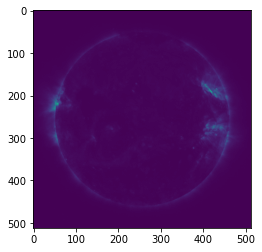

In [160]:
plt.imshow(t)

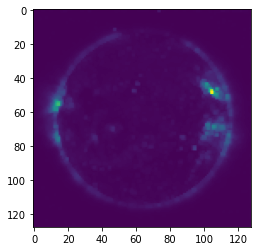

In [161]:
plt.imshow(t_nms)